# Principal Component Analysis

In [2]:
import consts
import helper
import importlib
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn, scipy, requests
import random
from sklearn.preprocessing import StandardScaler


In [3]:
FILE_PATH = consts.RAW_DATA_PATH_RYAN

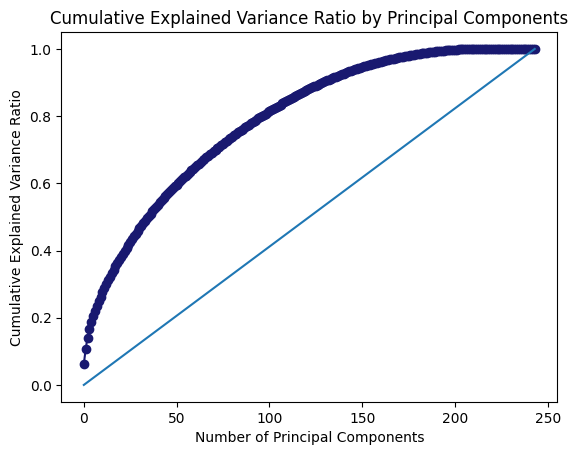

In [4]:
importlib.reload(helper)
df = pd.read_csv(FILE_PATH + 'data.20211223_1200')
df = df[df.columns[8:]] # cut out the test data
helper.pca_plot(df, num_components=244)

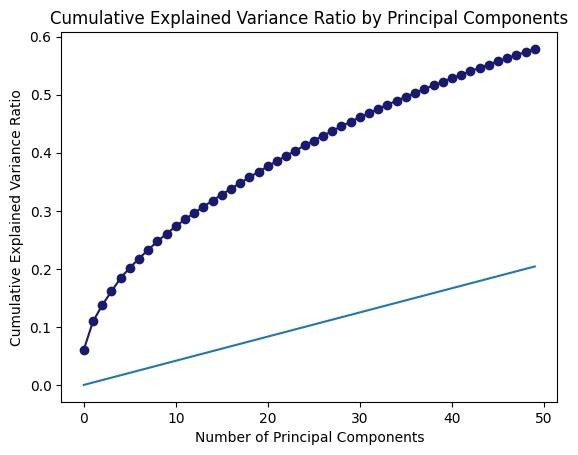

In [5]:
df = pd.read_csv(FILE_PATH + 'data.20200316_1200')
df.columns
df = df[df.columns[7:]] # cut out testing columns
helper.pca_plot(df, num_components=50)

## Regressions with PCA

In [5]:
USER = "RYAN"
RESPONSE_NAME = consts.RESPONSE_NAME

LASSO = "LASSO"
XGBOOST = "XGBOOST"

ALPHA = 0.05 # Set significance level

TEST_START  = "20191001"
TRAIN_TEST_GAP = 31 # days

In [7]:
importlib.reload(helper)
data = helper.Data(train_data_path=FILE_PATH)

train_df = data.update_and_get_train_df(TEST_START, backward_dayCount = 31, train_data_count=182)
response_cols = train_df.columns[:7]

# Drop response columns
validation_data = data.train_df[RESPONSE_NAME]

#get the transformed training data and remove high variance features
removable_features = []

highCorr_features_map = data.find_high_corr(.6)

for _, highCorr_pairs in highCorr_features_map.items():
    for (feature1, feature2) in highCorr_pairs:
        insig_features = helper.hypothesis_test_features(data.train_df, feature1, feature2, alpha = .01)
        removable_features.extend(insig_features)

data.train_df.drop(removable_features, axis = consts.COL, inplace=True)

# cut out response columns
for col in data.train_df.columns:
    if col in response_cols:
        data.train_df.drop([col], axis = consts.COL, inplace=True)

train_df = data.train_df
test_dfs = data.update_and_get_test_df(data_path = FILE_PATH, start_date=TEST_START, end_date="20200301")
important_cols = train_df.columns
test_xs = [df[important_cols] for df in test_dfs]


No YYYYMMDD datetime matched.

Getting files from 2019-03-02 00:00:00 to 2019-08-31 00:00:00, inclusive.
(220393, 167)
Getting files from 2019-10-01 00:00:00 to 2020-03-01 00:00:00, inclusive.


In [8]:
# Fit PCA

# # Scale the data
scalar = StandardScaler()
train_df = scalar.fit_transform(train_df) 

pca = sklearn.decomposition.PCA(n_components=37)
pca.fit(train_df)

# Fit Transform X training data
train_df_pca = pd.DataFrame(pca.transform(train_df))
# add on the original y values 
train_df_pca[RESPONSE_NAME] = validation_data.values # leave untransformed

scaled_test = [pd.DataFrame(scalar.fit_transform(df)) for df in test_xs]
transformed_test = [pd.DataFrame(pca.transform(df)) for df in scaled_test]
test_dfs_pca = []
for pca_df, df in zip(transformed_test, test_dfs):
    pca_df[RESPONSE_NAME] = df[RESPONSE_NAME]
    test_dfs_pca.append(pca_df)

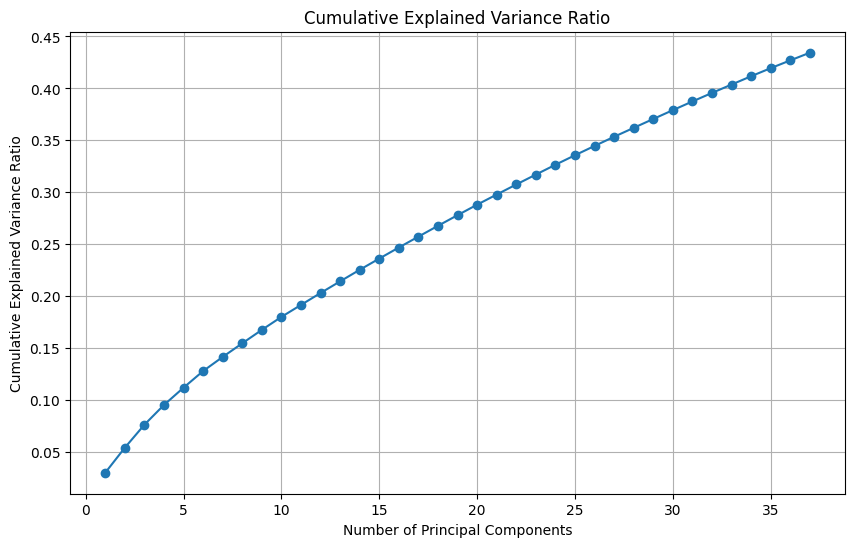

In [13]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [10]:
importlib.reload(helper)
full_ols_model = helper.Model('OLS')
full_ols_model.train(pd.DataFrame(train_df_pca))
predictions = full_ols_model.test(test_dfs_pca)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 37
response_corr: 0.06771080438270716
scale_factor: 1.3013642458055028
mean_return: 0.0005312090171907455


In [11]:
importlib.reload(helper)
lasso_model = helper.Model(LASSO)
lasso_model.train(pd.DataFrame(train_df_pca))
predictions = lasso_model.test(test_dfs_pca)

You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
No. features being used: 37
response_corr: 0.06718356021825284
scale_factor: 1.662824724278122
mean_return: 0.0005257366510244334


In [12]:
importlib.reload(helper)
xgboost_model = helper.Model(XGBOOST)
xgboost_model.train(pd.DataFrame(train_df_pca))
predictions = xgboost_model.test(test_dfs_pca)

You're using: XGBOOST.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_pa

In [ ]:
TEST_DATE = "20211201"

data = helper.Data(train_data_path=FILE_PATH)
train_df = data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1)
data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
TEST_DF = data.test_dfs[0]

model_PCA_OLS = helper.Model('OLS')
model_PCA_OLS.train(train_df)
model_PCA_OLS.test(TEST_DF)
helper.validation_plot(data, model_PCA_OLS, 10, TEST_DATE, train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15) #, features = [INSERT YOUR VARIABLE HERE])

In [15]:
TEST_DATE = "20211201"
importlib.reload(helper)
data = helper.Data(train_data_path=FILE_PATH)
train_df = data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1)
data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
####
# train_df = data.update_and_get_train_df(TEST_START, backward_dayCount = 1)
response_cols = train_df.columns[:7]

# Drop response columns
validation_data = data.train_df[RESPONSE_NAME]

#get the transformed training data and remove high variance features
removable_features = []

highCorr_features_map = data.find_high_corr(.6)

for _, highCorr_pairs in highCorr_features_map.items():
    for (feature1, feature2) in highCorr_pairs:
        insig_features = helper.hypothesis_test_features(data.train_df, feature1, feature2, alpha = .01)
        removable_features.extend(insig_features)

data.train_df.drop(removable_features, axis = consts.COL, inplace=True)

# cut out response columns
for col in data.train_df.columns:
    if col in response_cols:
        data.train_df.drop([col], axis = consts.COL, inplace=True)

train_df = data.train_df
test_dfs = data.update_and_get_test_df(data_path = FILE_PATH, start_date=TEST_START, end_date="20200301")
important_cols = train_df.columns
test_xs = [df[important_cols] for df in test_dfs]

scalar = StandardScaler()
train_df = scalar.fit_transform(train_df) 

pca = sklearn.decomposition.PCA(n_components=37)
pca.fit(train_df)

# Fit Transform X training data
train_df_pca = pd.DataFrame(pca.transform(train_df))
# add on the original y values 
train_df_pca[RESPONSE_NAME] = validation_data.values # leave untransformed

scaled_test = [pd.DataFrame(scalar.fit_transform(df)) for df in test_xs]
transformed_test = [pd.DataFrame(pca.transform(df)) for df in scaled_test]
test_dfs_pca = []
for pca_df, df in zip(transformed_test, test_dfs):
    pca_df[RESPONSE_NAME] = df[RESPONSE_NAME]
    test_dfs_pca.append(pca_df)
#### 

TEST_DF = test_dfs_pca[0] #data.test_dfs[0]

model_PCA_OLS = helper.Model('OLS')
model_PCA_OLS.train(train_df_pca)
model_PCA_OLS.test(TEST_DF)
helper.validation_plot(data, model_PCA_OLS, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features=range(37)) 

No YYYYMMDD datetime matched.

Getting files from 2021-11-29 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2019-10-01 00:00:00 to 2020-03-01 00:00:00, inclusive.
You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 37
response_corr: -0.020522183156101447
scale_factor: -0.09893327769482121
mean_return: -0.00031567726971504304
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.
range(0, 37)


KeyError: "None of [Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\n            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,\n            34, 35, 36],\n           dtype='int64')] are in the [columns]"

In [12]:
features_filename = "Hoang_classTree_genetic_features.txt"
with open(features_filename, 'r') as file: FEATURES = [line.strip("\n") for line in file]
FEATURES

['today',
 'tmwam',
 'dn1',
 'llirpnxm_dy_1to3',
 'llirpnxm_dy_7to11',
 'llirpnxm_nt_1',
 'llirpnxm_pm_1',
 'llirpnxm_toxhr_0',
 'mocrelvol_open_18to22',
 'moorelvol_open_1to3',
 'nnetticksrelmultstdev_dy_1to3',
 'nnetticksrelmultstdev_nt_12to16',
 'nnetticksrelmultstdev_toxhr_0',
 'nsameticksrelmultstdev_dy_1to3',
 'nsameticksrelmultstdev_lst15_0',
 'nsameticksrelmultstdev_lsthrx15_0',
 'nsameticksrelmultstdev_nt_0',
 'nsameticksrelmultstdev_nt_1to3',
 'nsameticksrelmultstdev_nt_4to6',
 'nsameticksrelmultstdev_nt_7to11',
 'nsameticksrelmultstdev_toxhr_0',
 'nsameticksrelrrsign_toxhr_0',
 'rel2retcfrtxm_dy_12to16',
 'rel2retcfrtxm_dy_1to3',
 'rel2retcfrtxm_dy_7to11',
 'rel2retcfrtxm_lsthrx15_0',
 'relavgts70tr_close_12to16',
 'relavgts70tr_now_0',
 'relvol_am_1',
 'relvol_dy_4to6',
 'relvol_lsthrx15_0',
 'relvol_md_1',
 'relvol_nt_0']